In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import itertools
import scipy
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as Data
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

from produce_dataset import *

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
ntuple_dir = '/ecoderemdvol/econ_ntuples/qk/'
root_dir = 'FloatingpointAEttbarDummyHistomaxGenmatchGenclustersntuple'

df_econ = loadEconData(ntuple_dir,root_dir,'econ_data.csv',False)

df_gen = loadGenData(ntuple_dir,root_dir,'gen_data.csv')

In [146]:
df_nodes=df_econ[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
        'wafer_energy', 'tc_eta', 'tc_phi']]
df_nodes.reset_index(inplace=True)

count = (df_econ['wafer_energy'] != 0).sum()
print('e wafers: '+str(count)+', out of: '+str(len(df_econ['wafer_energy']))+' or  '+ str(round(count/len(df_econ['wafer_energy'])*100,2))+'%')

e wafers: 2903, out of: 18697 or  15.53%


In [198]:
cols = ['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15']

#find sum of columns specified 
df_nodes['sum'] = df_nodes[cols].sum(axis=1);

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


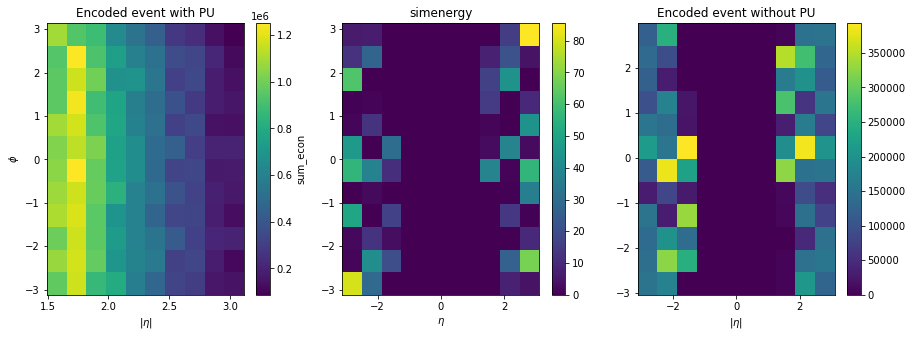

In [5]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.subplot(1,3,1)
h1 = plt.hist2d(x=abs(df_nodes['tc_eta']),y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h1[3],label='sum_econ')
plt.xlabel(r'$|\eta|$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');
plt.subplot(1,3,2)
h2 = plt.hist2d(x=df_nodes['tc_eta'],y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['wafer_energy'])
fig.colorbar(h2[3])
plt.xlabel(r'$\eta$');
plt.title('simenergy');
df_nodes_w_simenergy = df_nodes[df_nodes.wafer_energy>0]
plt.subplot(1,3,3)
h3 = plt.hist2d(x=(df_nodes_w_simenergy['tc_eta']),y=df_nodes_w_simenergy['tc_phi'],bins=(10,12),weights=df_nodes_w_simenergy['sum'])
fig.colorbar(h3[3])
plt.xlabel(r'$|\eta|$');
plt.title('Encoded event without PU');

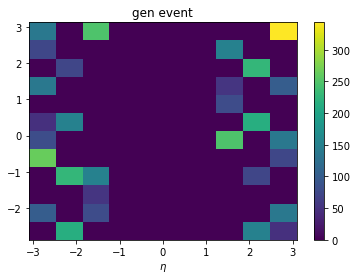

In [20]:
h = plt.hist2d(x=(df_gen['eta']),y=df_gen['phi'],bins=(10,12),weights=df_gen['pt'])
plt.colorbar(h[3])
plt.xlabel(r'$\eta$');
plt.title('gen event');

In [21]:
df_gen

,pt,energy,eta,phi
0,184.546875,551.127075,1.757919,-0.197900
1,184.546875,551.127075,-1.757919,2.943693
2,72.926064,794.530029,-3.079339,-1.924672
3,72.926064,794.530029,3.079339,1.216921
4,149.965668,582.781799,-2.033572,-2.741254
5,149.965668,582.781799,2.033572,0.400339
6,47.179691,380.669128,-2.777252,0.533057
7,47.179691,380.669128,2.777252,-2.608536
8,79.224037,524.226318,2.577032,2.950521
9,79.224037,524.226318,-2.577032,-0.191071


event for 40 electrons

In [22]:
def build_graph(df_econ,
            df_gen,
            phi_min,
            phi_max):

    #only choose wafers in some phi range now
    
    df_econ = df_econ[df_econ.tc_phi>phi_min][df_econ.tc_phi<phi_max];
    
    df_nodes=df_econ[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
           'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
            'wafer_energy', 'tc_eta', 'tc_phi']]
    df_nodes.reset_index(inplace=True)
    
    embeddings = torch.tensor(df_nodes.values)

    eta=df_nodes['tc_eta']
    phi=df_nodes['tc_phi']
    idx = range(len(eta))
    indices_i = np.array([i for i,j in itertools.product(idx,idx)])
    indices_j = np.array([j for i,j in itertools.product(idx,idx)])

    del_R = np.empty([len(eta),len(eta)])
    del_R.shape

    for (i, j) in zip(indices_i,indices_j):
        del_R[i][j]=np.sqrt((eta[i]-eta[j])**2+((phi[i]-phi[j])%(2*np.pi))**2)

    del_R = torch.tensor(del_R)

    adj = np.zeros([len(eta),len(eta)])
    for (i, j) in zip(indices_i,indices_j):
        if del_R[i][j] <0.045 and  del_R[i][j]> 0 :
            adj[i][j]=1.0

    adj=torch.tensor(adj) 

    edge_index = (adj > 0.0).nonzero().t()
    edge_index.shape

    #predict node level feature: PU vs electron per simenergy

    feature_df= df_econ['wafer_energy']
    # label PU as 0, electron wafers as 1
    labels = (feature_df.where(feature_df==0,other=1))
    features = torch.tensor(labels.values).to(torch.long)

    graph = Data.Data(x=embeddings, edge_index=edge_index, y=features)
    graph.num_classes=2
    return graph,df_nodes

In [23]:
graphs = []
cut_event_dfs=[]

In [24]:
for gen_phi in df_gen['phi']:
    # only build graph in 15 degree range around electron gen_phi
    phi_min,phi_max= gen_phi-np.pi/24,gen_phi+np.pi/24
    graph, cut_event_df = build_graph(df_econ,df_gen,phi_min,phi_max)
    graphs.append(graph);
    cut_event_dfs.append(cut_event_df)  

/tmp/ipykernel_281/2159033323.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_econ = df_econ[df_econ.tc_phi>phi_min][df_econ.tc_phi<phi_max];


In [266]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(graphs[0].num_features, 64)
        self.conv2 = GCNConv(64, graphs[0].num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [267]:
device = torch.device('cuda')
model = GCN().to(device)
model = model.double()

In [268]:
data = graphs[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

val_data = graphs[1].to(device)

In [279]:
cut_event_df = cut_event_dfs[1]

In [280]:
cut_event_df[cut_event_df.wafer_energy>0]
count = (cut_event_df['wafer_energy'] != 0).sum()
print('e wafers: '+str(count)+', out of: '+str(len(cut_event_df['wafer_energy']))+' or  '+ str(round(count/len(cut_event_df['wafer_energy'])*100,2))+'%')

e wafers: 39, out of: 698 or  5.59%


In [281]:
train_loss_arr = []
val_loss_arr = []
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    #loss = F.cross_entropy(torch.sigmoid(out), data.y, weight=torch.tensor(np.asarray([1,2.6]).astype('double')).to(device))
    loss = F.nll_loss(out,data.y,weight=torch.tensor(np.asarray([1.0,2.6]).astype('double')).to(device))
    val_pred = model(val_data)
    val_loss = F.nll_loss(val_pred,val_data.y,weight=torch.tensor(np.asarray([1.0,16.9]).astype('double')).to(device))
    train_loss_arr.append(loss)
    val_loss_arr.append(val_loss)
    loss.backward()
    optimizer.step()

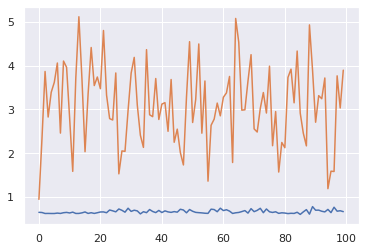

In [282]:
plt.plot(range(100),train_loss_arr)
plt.plot(range(100),val_loss_arr)

In [272]:
model.eval()
train_pred = model(data).argmax(dim=1)
correct = (train_pred == data.y).sum()
train_acc = int(correct)/graphs[0].y.size(dim=0)
print(f'Accuracy: {train_acc:.4f}')

Accuracy: 0.4658


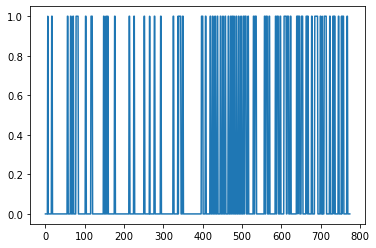

In [202]:
xtest=train_pred.cpu().numpy()
plt.plot(range(len(xtest)),xtest)

In [203]:
acc_array=[]
pred_array=[]
for graph in graphs:
    val_data=graph.to(device)
    pred = model(val_data).argmax(dim=1)
    pred_array.append(pred)
    correct = (pred == val_data.y).sum()
    acc = int(correct)/val_data.y.size(dim=0)
    acc_array.append(acc)

print(f'Accuracy: {np.asarray(acc_array).mean():.4f}')

Accuracy: 0.7752


In [204]:
for i in range(len(graphs)):
    cut_event_dfs[i]['pred_label'] =  pred_array[i].cpu().numpy()
    
GNN_PU_removed_event_dfs=[]
for i in range(len(graphs)):
    app = cut_event_dfs[i]
    GNN_PU_removed_event_dfs.append(app[app.pred_label==1])
    
GNN_PU_removed_event=GNN_PU_removed_event_dfs[0]
for i in range(1,len(graphs)):
    app = GNN_PU_removed_event_dfs[i]
    GNN_PU_removed_event=pd.concat([GNN_PU_removed_event,app])
    
GNN_PU_removed_event['sum'] = GNN_PU_removed_event[cols].sum(axis=1);

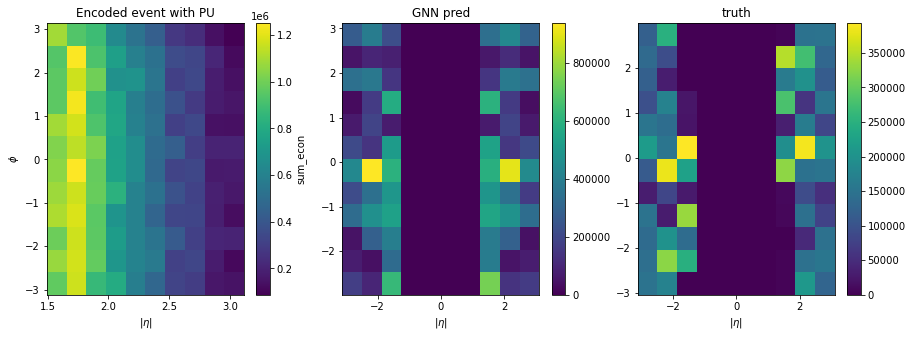

In [205]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.subplot(1,3,1)
h1 = plt.hist2d(x=abs(df_nodes['tc_eta']),y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h1[3],label='sum_econ')
plt.xlabel(r'$|\eta|$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');
plt.subplot(1,3,2)
h2 = plt.hist2d(x=(GNN_PU_removed_event['tc_eta']),y=GNN_PU_removed_event['tc_phi'],bins=(10,12),weights=GNN_PU_removed_event['sum'])
fig.colorbar(h2[3])
plt.xlabel(r'$|\eta|$');
plt.title('GNN pred');
plt.subplot(1,3,3)
h3 = plt.hist2d(x=(df_nodes_w_simenergy['tc_eta']),y=df_nodes_w_simenergy['tc_phi'],bins=(10,12),weights=df_nodes_w_simenergy['sum'])
fig.colorbar(h3[3])
plt.xlabel(r'$|\eta|$');
plt.title('truth');

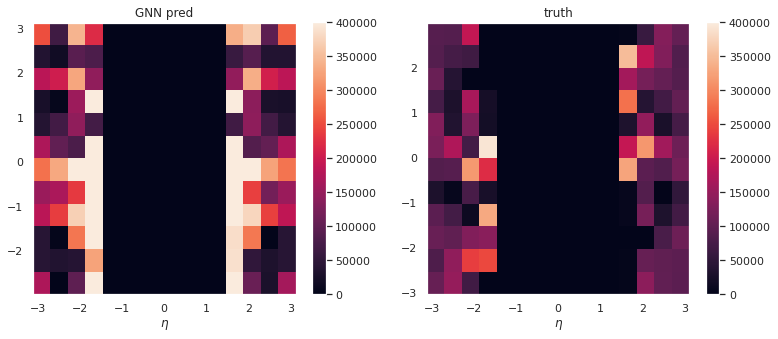

In [263]:
fig, axes = plt.subplots(1,2,figsize=(20,5))
plt.subplot(1,3,1)
h2 = plt.hist2d(x=(GNN_PU_removed_event['tc_eta']),y=GNN_PU_removed_event['tc_phi'],bins=(15,12),weights=GNN_PU_removed_event['sum'],vmin=0,vmax=400000)
fig.colorbar(h2[3])
plt.xlabel(r'$\eta$');
plt.title('GNN pred');
plt.subplot(1,3,2)
h3 = plt.hist2d(x=(df_nodes_w_simenergy['tc_eta']),y=df_nodes_w_simenergy['tc_phi'],bins=(15,12),weights=df_nodes_w_simenergy['sum'],vmin=0,vmax=400000)
fig.colorbar(h3[3])
plt.xlabel(r'$\eta$');
plt.title('truth');